# Sentiment Analysis

# PART 5

## Installs, Imports and Paths

In [1]:
set 
PYTORCH_CUDA_ALLOC_CONF="garbage_collection_threshold:0.6,max_split_size_mb:128"

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
!pip install -U scikit_learn
!pip install -U nltk
!pip install -U datasets
!pip install --upgrade tensorflow
!pip install scipy
!pip install --upgrade scikeras
!pip install -U tensorflow-gpu
!pip install keras-self-attention
!pip install transformers
!pip install optuna
!pip install wandb
!pip install ray[tune]

In [4]:
import numpy as np
import re
import warnings
import random
import nltk
import urllib.request, zipfile
import tensorflow as tf
import os
import scipy
import keras
import random
import torch
import pandas as pd
import torch
from ray.tune.schedulers import PopulationBasedTraining
from tensorflow.keras import backend as K
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import load_dataset
from collections import Counter
from sklearn.metrics import accuracy_score
from nltk import sent_tokenize, word_tokenize, pos_tag
from tabulate import tabulate
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from google.colab import files
from ray import tune

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
stemmer = WordNetLemmatizer()
warnings.filterwarnings("ignore")
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [20]:
!wandb login

/bin/bash: wandb: command not found


In [21]:
%env WANDB_LOG_MODEL = true

env: WANDB_LOG_MODEL=true


In [22]:
%env WANDB_PROJECT = sentiment-analysis

env: WANDB_PROJECT=sentiment-analysis


In [23]:
%env WANDB_NOTEBOOK_NAME = "/content/Sentiment-Analysis-Part-5"

env: WANDB_NOTEBOOK_NAME="/content/Sentiment-Analysis-Part-5"


In [24]:
if not os.path.exists('./Sentiment-Analysis'):
  os.makedirs('./Sentiment-Analysis')
os.chdir('./Sentiment-Analysis')

## Data Preprocessing

### Dataset Loading

In [25]:
def remove(text, polarity, n):
    for _ in range(int(len(text)*n)):
        number = random.randrange(0,len(text))
        text.pop(number)
        polarity.pop(number)
    return

#importing the dataset
tweets = load_dataset("tweet_eval",'sentiment')

#create train/dev/test sets 
train = tweets['train']
dev = tweets['validation']
test = tweets['test']

x_train = train['text']
x_val = dev['text'] 
x_test = test['text']

y_train = train['label'] 
y_val = dev['label']
y_test = test['label']

#removing big parts because of too many data
#remove(x_train, y_train, 0.5)
#remove(x_val, y_val, 0.2)
#remove(x_test, y_test, 0.5)

print("Training Data Size: ", len(x_train))
print("Evaluation Data Size: ", len(x_val))
print("Test Data Size: ", len(x_test))


  0%|          | 0/3 [00:00<?, ?it/s]

Training Data Size:  45615
Evaluation Data Size:  2000
Test Data Size:  12284


### Heuristic for text-classification

In [26]:
total_size = []
for sent in x_train:
  internal_c = 0
  for word in sent:
    internal_c += 1
  total_size.append(internal_c)

sum = 0
for i in range(len(total_size)):
  sum += total_size[i]

mean = sum/len(total_size)

print(len(x_train))
print(mean)
print(len(x_train)/mean)

45615
106.93285103584347
426.57611349677785


## Prepare the ground for BERT

### Preview Data

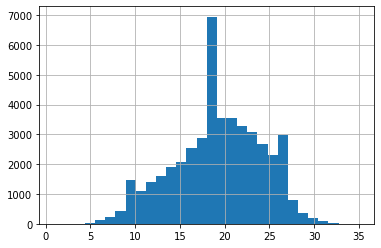

In [27]:
seq_len = [len(i.split()) for i in x_train]
pd.Series(seq_len).hist(bins=30)
# max sequence length for each document/sentence sample
max_length = 25

### Load Model and adjust Data

In [28]:
# Load BERT's (WordPiece) tokenizer
# Uncased model -> lowercase characters
model_name = "bert-base-uncased"
#target_list = ['0', '1', '2']
tokenizer_1 = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_ac

In [29]:
# Tokenize the dataset at max_length, using truncation and padding
train_encodings = tokenizer_1(x_train, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer_1(x_val, truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer_1(x_test, truncation=True, padding=True, max_length=max_length)

In [30]:
# DataLoader consists of encodings (Xs) and labels (Ys)
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        #every key has a list as value (list of samples)
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# Convert our tokenized data into a torch Dataset
train_dataset = SentimentDataset(train_encodings, y_train)
valid_dataset = SentimentDataset(valid_encodings, y_val)
test_dataset = SentimentDataset(test_encodings, y_val)

In [31]:
target_list = [0, 1, 2]
# Load a BERT model for *text classification* 

"""
    This is a classic Bert Model transformer 
    with a sequence classification/regression head on top 
    (a linear layer on top of the pooled output) 
"""
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(target_list))

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /

## BERT

In [32]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size= 16,  # batch size per device during training
    per_device_eval_batch_size= 20,   # batch size for evaluation
    warmup_steps=300,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay. The weight decay to apply (if not zero) to all layers except all bias and LayerNorm weights in AdamW optimizer.
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=10,               # log & save weights each logging_steps
    evaluation_strategy="steps",     # The evaluation strategy to adopt during training. Evaluation is done (and logged) every `logging_steps`
)

using `logging_steps` to initialize `eval_steps` to 10
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [33]:
# Custom metric method
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  f1 = f1_score(labels, preds, average = 'macro')
  return {
      'accuracy': acc,
      'f1': f1
  }

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

with tf.device('/device:GPU:0'):
  trainer = Trainer(
      model=model,                         # the instantiated Transformers model to be trained
      args=training_args,                  # training arguments, defined above
      train_dataset=train_dataset,         # training dataset
      eval_dataset=valid_dataset,          # evaluation dataset
      compute_metrics=compute_metrics,     # the callback that computes metrics of interest
  )

  trainer.train()

### Evaluate and Save Model

In [35]:
# Evaluate the current model after training
trainer.evaluate()

# Save the fine-tuned model and the tokenizer
model_path = "sent-anal-bert-base-uncased"
model.save_pretrained(model_path)
tokenizer_1.save_pretrained(model_path)

***** Running Evaluation *****
  Num examples = 2000
  Batch size = 20


Configuration saved in sent-anal-bert-base-uncased/config.json
Model weights saved in sent-anal-bert-base-uncased/pytorch_model.bin
tokenizer config file saved in sent-anal-bert-base-uncased/tokenizer_config.json
Special tokens file saved in sent-anal-bert-base-uncased/special_tokens_map.json


('sent-anal-bert-base-uncased/tokenizer_config.json',
 'sent-anal-bert-base-uncased/special_tokens_map.json',
 'sent-anal-bert-base-uncased/vocab.txt',
 'sent-anal-bert-base-uncased/added_tokens.json',
 'sent-anal-bert-base-uncased/tokenizer.json')

### Load Model

In [36]:
# Load model and tokenizer
model = BertForSequenceClassification.from_pretrained("sent-anal-bert-base-uncased", num_labels=len(target_list)).to("cuda")
tokenizer_2 = BertTokenizerFast.from_pretrained(model_path)

loading configuration file sent-anal-bert-base-uncased/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file sent-a

### Model Assessment

In [37]:
def get_prediction(text):
    # prepare our text into tokenized sequence
    inputs = tokenizer_2(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    # executing argmax function to get the candidate label
    return target_list[probs.argmax()]

def get_probabilities(x):
  y_proba = []
  for sent in x:
    inputs = tokenizer_2(sent, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    y_proba.append(probs)
  return y_proba

In [38]:
with tf.device('/device:GPU:0'):
  def predictions(x_test):
    y_pred = []
    for sentence in x_test:
      y_pred.append(int(get_prediction(sentence)))

    return y_pred

  y_pred_train = predictions(x_train)
  y_pred_val = predictions(x_val)
  y_pred_test = predictions(x_test)
  
  K.clear_session()

In [39]:
with tf.device('/device:GPU:0'):

  m_train_f1_score = f1_score(y_train, y_pred_train, average = 'macro')
  print("Train f1-score: {:.2f}% \n".format(m_train_f1_score*100))

  m_val_f1_score = f1_score(y_val, y_pred_val, average = 'macro')
  print("Evaluation f1-score: {:.2f}% \n".format(m_val_f1_score*100))

  m_test_f1_score = f1_score(y_test, y_pred_test, average = 'macro')
  print("Test f1-score: {:.2f}% \n".format(m_test_f1_score*100))

Train f1-score: 90.43% 

Evaluation f1-score: 68.88% 

Test f1-score: 66.21% 



### Precision, Recall, AUC, ROC-AUC

In [40]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [41]:
def alter_labels(data, status):
  temp = []
  for i in range(len(data)):
    if status == 'add':
      temp.append(data[i]+ 1)
    if status == 'subtract':
      temp.append(data[i] - 1)
  return temp

In [42]:
def calculate_Bert_Results(x, y_true, y_pred):

  y_pred_enc = alter_labels(y_pred, 'subtract') # 0,1,2
  y_true_enc = alter_labels(y_true, 'subtract') # 0,1,2

  train_precision_score = precision_score(y_true_enc, y_pred_enc, average = None)
  train_recall_score = recall_score(y_true_enc, y_pred_enc, average = None)
  train_f1_score = f1_score(y_true_enc, y_pred_enc, average = None)


  m_train_precision_score = precision_score(y_true_enc, y_pred_enc, average = 'macro')
  m_train_recall_score = recall_score(y_true_enc, y_pred_enc, average = 'macro')
  m_train_f1_score = f1_score(y_true_enc, y_pred_enc, average = 'macro')

  y_pred_onehot = np.eye(len(np.unique(y_pred_enc)))[y_pred_enc]

  # One-hot encode the true class labels
  y_true_onehot = np.eye(len(np.unique(y_true_enc)))[y_true_enc]


  m_train_roc_auc_score = roc_auc_score(y_true_onehot, y_pred_onehot, multi_class= 'ovr', average = 'macro')


  table = [['    ', 'Precision', 'Recall', 'F1', 'AUC', 'Macro-Precision', 'Macro-Recall', 'Macro-F1', 'Macro-AUC'], 
        ['Positive', round(train_precision_score[0], 3), round(train_recall_score[0], 3), round(train_f1_score[0], 3),'-', '-', '-', '-'],
        ['Neutral', round(train_precision_score[1], 3), round(train_recall_score[1], 3), round(train_f1_score[1], 3), '-', '-', '-', '-'],
        ['Negative', round(train_precision_score[2], 3), round(train_recall_score[2], 3), round(train_f1_score[2], 3), '-', '-', '-', '-'],
        ['Total', '-', '-','-','-', round(m_train_precision_score, 3), round(m_train_recall_score, 3), round(m_train_f1_score, 3), round(m_train_roc_auc_score, 3)]]

  print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

In [43]:
print("Bert ---------------------------------------------------------------------------------------------------------\n")

print("The training results: \n")
calculate_Bert_Results(x_train, y_train, y_pred_train)

print("The evaluation results: \n")
calculate_Bert_Results(x_val, y_val, y_pred_val)

print("The test results: \n")
calculate_Bert_Results(x_test, y_test, y_pred_test)

Bert ---------------------------------------------------------------------------------------------------------

The training results: 

╒══════════╤═════════════╤══════════╤═══════╤═══════╤═══════════════════╤════════════════╤════════════╤═════════════╕
│          │ Precision   │ Recall   │ F1    │ AUC   │ Macro-Precision   │ Macro-Recall   │ Macro-F1   │   Macro-AUC │
╞══════════╪═════════════╪══════════╪═══════╪═══════╪═══════════════════╪════════════════╪════════════╪═════════════╡
│ Positive │ 0.907       │ 0.884    │ 0.896 │ -     │ -                 │ -              │ -          │             │
├──────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ Neutral  │ 0.917       │ 0.884    │ 0.9   │ -     │ -                 │ -              │ -          │             │
├──────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ Negative │ 0.895       │ 0.941    │ 

### Hyper Parameter Tuning

In [ ]:
def model_init():
    return BertForSequenceClassification.from_pretrained("/content/Sentiment-Analysis/Sentiment-Analysis/sent-anal-bert-base-uncased", num_labels=len(target_list), return_dict=True).to("cuda")

def get_scheduler():
    #Creating the PBT scheduler
    scheduler = PopulationBasedTraining(
        mode = "max",
        metric='eval_f1',
        perturbation_interval=2,
        hyperparam_mutations={
            "weight_decay": tune.uniform(0.0, 0.3),
            "learning_rate": tune.uniform(1e-5, 5e-5),
            "per_device_train_batch_size": tune.choice([8, 16, 24, 32, 48]),
            "num_train_epochs": tune.choice([3, 4, 5]),
            "warmup_steps": tune.choice(range(0, 500))
        }
    )
    return scheduler

hyper_parameter_args = TrainingArguments("test", report_to = "wandb", eval_steps=500, disable_tqdm=True)

hyper_trainer = Trainer(
    args=hyper_parameter_args, 
    data_collator=DataCollatorWithPadding(tokenizer_2),
    model_init=model_init,
    compute_metrics=compute_metrics,
)

hyper_trainer.hyperparameter_search(
    direction="maximize",
    backend="wandb",
    train_dataset=train_dataset, 
    eval_dataset=valid_dataset,
    n_trials=4,
    keep_checkpoints_num=1,
    scheduler=get_scheduler(),
    verbose=1
)